# Calculating the Laguerre polynomials
We will calculate these polynomials with the following recurrent formula:
$$
L_{k+1}^{(\alpha)}(x)=\frac{(2k+1+\alpha-x)L_k^{(\alpha)}(x)-(k+\alpha)L_{k-1}^{(\alpha)}(x)}{k+1},
$$
where $L^{(\alpha)}_0(x)=1$ and $L^{(\alpha)}_1(x)=1+\alpha-x$.

Here we use a special decorator for caching:

In [1]:
import c_code.laguerre_module as cl

def cached(func):
    """
    A decorator which caches values for pure functions
    """
    cache = {}

    def wrapper(*args):
        if args in cache:
            return cache[args]
        result = func(*args)
        cache[args] = result
        return result

    return wrapper

The function that calculates the Laguerre polynomials:

In [2]:
def laguerre_c(k, alpha, x):
    return cl.py_laguerre_iterative(k, alpha, x)


@cached
def laguerre_python(k, alpha, x):
    if k == 0:
        return 1
    elif k == 1:
        return -x + alpha + 1

    _a = (2 * k - 1 + alpha - x) / k
    _b = (k + alpha - 1) / k

    return _a * laguerre_python(k - 1, alpha, x) - _b * laguerre_python(k - 2, alpha, x)


def laguerre(k, alpha, x):
    return laguerre_c(k, alpha, x)

Here we test our function. If you want to plot $L_n^{(\alpha)}$ change the values $n$ and $alpha$ in the code below. The values $a$ and $b$ allow to change the segment on which we draw the polynomial and $density$ controls the drawing precision.

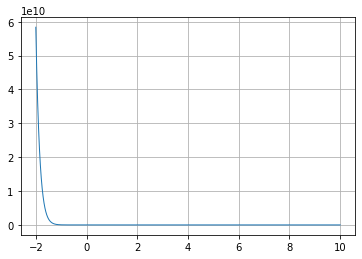

In [7]:
import matplotlib.pyplot as plt

# the order of the polynomials
n = 100
alpha = 0

# the density of the grid
density = 1000

# the segment on which the polynomial is drawn
a = -2
b = 10

xs = [a + (b-a)/density * i for i in range(density+1)]
ys = [laguerre(n, alpha, x) for x in xs]

plt.plot(xs, ys, linewidth=1, label=f'The Laguerre polynomials of order {n}')
plt.grid()
plt.show()

Now we want to calculate the roots of this polynomial. We will use the function ```find_all_roots_of_laguerre``` to do this. The parameter ```epsilon``` is used to stop iteration when the precision of the solution is less than it.

In [8]:
@cached
def find_root_of_laguerre(k, alpha, a, b, epsilon):
    """
    Finds the root of the Laguerre polynomials of order k on the segment [a,b].
    The root must be single.
    """
    mid_point = (a + b) / 2
    fa = laguerre(k, alpha, a)
    fb = laguerre(k, alpha, b)
    fc = laguerre(k, alpha, mid_point)

    if abs(a - b) < epsilon:
        return (a + b) / 2

    if fa * fb > 0:
        raise Exception("The function should have different signs at the ends")

    if abs(fc) < epsilon:
        return mid_point

    elif fa * fc < 0:
        return find_root_of_laguerre(k, alpha, a, mid_point, epsilon)
    else:
        return find_root_of_laguerre(k, alpha, mid_point, b, epsilon)


@cached
def find_all_roots_of_laguerre(k, alpha, epsilon = 1e-12):
    """
    Finds all k roots of the Laguerre polynomials of order k
    :param k: the order of the polynomials
    :param alpha: a parameter of the Laguerre polynomials
    :return: the array containing all the k roots roots[0], ...,roots[k-1]
    """
    max_bound = 4 * k + 2

    segments = {1: [(0, max_bound)]}
    roots = dict()

    for j in range(1, k + 1):
        layer_roots = []
        for s in segments[j]:
            left_end = s[0]
            right_end = s[1]
            segment_root = find_root_of_laguerre(j, alpha, left_end, right_end, epsilon)
            layer_roots.append(segment_root)

        next_segments = [(0, layer_roots[0])]
        for i in range(len(layer_roots) - 1):
            next_segments.append((layer_roots[i], layer_roots[i + 1]))
        next_segments.append((layer_roots[-1], max_bound))

        segments[j + 1] = next_segments
        roots[j] = layer_roots

    return roots[k]

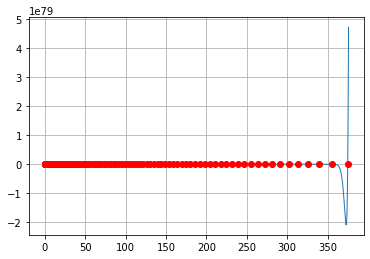

In [9]:
roots = find_all_roots_of_laguerre(n, alpha)

# the segment on which the polynomial is drawn
a = min(roots) - 1
b = max(roots) + 1

xs = [a + (b-a)/density * i for i in range(density+1)]
ys = [laguerre(n, alpha, x) for x in xs]

zeros = [0 for _ in roots]

plt.plot(xs, ys, linewidth=1, label=f'The Laguerre polynomials of order {n}')
plt.plot(roots, zeros, marker='o', color='r', ls='')
plt.grid()
plt.show()

In [10]:
# Testing the speed
import time

def function_for_profiling():
    _n = 100
    _alpha = 0
    return find_all_roots_of_laguerre(_n, _alpha)

import cProfile

print(cProfile.run('function_for_profiling()'))

         5 function calls in 0.000 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <ipython-input-1-aab8ab91074f>:9(wrapper)
        1    0.000    0.000    0.000    0.000 <ipython-input-10-b088470e5c31>:4(function_for_profiling)
        1    0.000    0.000    0.000    0.000 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}


None


Here we calculate weights using the formula
$$
A_i^M = \frac{1}{\tau_i^M}\left[\frac{1}{L^{(1)}_{M-1}(\tau_i^M)}\right]^2
$$
for $i=0,1,2,\ldots,M-1$, where $M$ is the order of the Laguerre polynomial, $\left\{\tau_i^M\right\}_{i=0}^{M-1}$ is the roots of the polynomial. We assume that $\alpha = 0$ otherwise the formula would be different.

In [11]:
@cached
def root_to_weight(root, k, alpha):
    """
    Given one root of the Laguerre polynomials of order k, calculates the corresponding weight
    :param root:
    :param k: int
    :return:
    """
    return 1.0 / root / ((laguerre(k - 1, 1, root)) ** 2)


@cached
def all_weights(_k, _alpha):
    _roots = find_all_roots_of_laguerre(_k, _alpha)
    return [root_to_weight(root, _k, _alpha) for root in _roots]

We check the above function for ```n=32```. We should get approximately the following weights:
```
0,109218341953551; 0,210443107938996; 0,235213229669841; 0,195903335972852; 0,129983786286025; 0,0705786238656435; 0,0317609125091945; 0,0119182148348296; 0,00373881629460919; 0,000980803306615199; 0,000214864918801345; 3,92034196798651E-05; 5,93454161287654E-06; 7,41640457866401E-07; 7,60456787911671E-08; 6,3506022266307E-09; 4,28138297104417E-10; 2,30589949189201E-11; 9,79937928872355E-13; 3,23780165772521E-14; 8,17182344341286E-16; 1,54213383339424E-17; 2,11979229016417E-19; 2,05442967378971E-21; 1,34698258663885E-23; 5,66129413040054E-26; 1,41856054546278E-28; 1,91337549445178E-31; 1,1922487600965E-34; 2,67151121923763E-38; 1,33861694210782E-42; 4,5105361938963E-48;
```

In [12]:
n = 32
alpha = 0

weights = all_weights(n, alpha)

print(weights)

[0.10921834195289816, 0.21044310793887744, 0.23521322966983718, 0.19590333597284199, 0.12998378628609572, 0.07057862386571757, 0.03176091250917446, 0.011918214834838771, 0.003738816294612394, 0.0009808033066146188, 0.00021486491880139304, 3.920341967986227e-05, 5.934541612868265e-06, 7.41640457866891e-07, 7.60456787911813e-08, 6.350602226627662e-09, 4.281382971041071e-10, 2.3058994918915637e-11, 9.799379288730549e-13, 3.237801657731592e-14, 8.171823443420056e-16, 1.5421338333945017e-17, 2.119792290163158e-19, 2.054429673788438e-21, 1.3469825866368598e-23, 5.661294130399594e-26, 1.4185605454620546e-28, 1.913375494454746e-31, 1.1922487600983227e-34, 2.67151121924064e-38, 1.3386169421063509e-42, 4.510536193899104e-48]


Now we calculate the function
$$
{l}_{1,j+1}(\tau;b)=\frac{\sqrt{b}\tau L_{j}^1(b\tau)}{j+1}, \quad j=0,1,\ldots.
$$

In [13]:
@cached
def sobolev_laguerre(tau, b, j):
    return math.sqrt(b) * tau * laguerre(j - 1, 1, b * tau) / j

The next step is to calculate
$$
g(\tau)=f\left(1-e^{-a\tau},\eta(0)+ \sum\limits_{j=0}^{N} c_jl_{1,j+1}(\tau;b)\right)L_{k}(\tau;b)e^{(1-a-b)\tau}.
$$

In [14]:
def g(tau, _k, _a, _b, _c, _alpha, n_part):
    first_arg = 1 - math.exp(-_a * tau)
    s0 = sum([_c[j] * sobolev_laguerre(tau, _b, j + 1) for j in range(n_part + 1)])
    second_arg_sum_c_sobolev_laguerre = y0 + s0
    s1 = math.sqrt(b) * laguerre(_k, 0, tau * _b) * math.exp((1 - _a - _b) * tau)
    return f(first_arg, second_arg_sum_c_sobolev_laguerre) * s1

The following function calculates one iteration for finding coefficients $c_i$ which we will use later for finding the solution.
$$
c_k = 
a\int_{0}^\infty e^{-a\tau}f\left(1-e^{-a\tau},\eta(0)+ \sum\limits_{j=0}^{N} c_jl_{1,j+1}(\tau;b)\right)L_{k}(\tau;b)e^{-b\tau}d\tau\approx
a\sum_{i=1}^M A_i^M g(\tau_i^M),
$$
for $k=0,1,\ldots,N$, where N is the order of the partial sum (we use the variable ```n_part``` for it below). We also use ```n``` for $M$.

In [15]:
def perform_iteration_on_c(c0, _a, _b, _k, _alpha, n_part, _n):
    """
    :param c0: a _k+1 array
    :param _a:
    :param _b:
    :param _k:
    :param _alpha:
    :param n_part:
    :return:
    """
    weights = all_weights(_n, _alpha)
    _roots = find_all_roots_of_laguerre(_n, _alpha)
    gs = [g(root, _k, _a, _b, c0, _alpha, n_part) for root in _roots]

    return _a * sum([weights[i] * gs[i] for i in range(_n)])


def perform_iteration_on_cs(c0, _a, _b, _alpha, n_part, _n):
    return [perform_iteration_on_c(c0, _a, _b, k, _alpha, n_part, _n) for k in range(n_part+1)]

This function calculates the distance between two vectors.

In [16]:
def distance(c0, c1):
    _n = len(c0)
    return math.sqrt(sum([(c0[i] - c1[i]) ** 2 for i in range(_n)]))

This function performs iterations until the distance is small enough.

In [17]:
def find_cs(_k, _a, _b, _alpha, threshold, n_part, _n):
    c0 = [1/(i+1) for i in range(n_part+1)]
    c1 = perform_iteration_on_cs(c0, _a, _b, _alpha, n_part, _n)

    while distance(c0, c1) > threshold:
        c0 = c1
        c1 = perform_iteration_on_cs(c0, _a, _b, _alpha, n_part, _n)

    return c1

Now we can find the solution:
$$
\eta(t) = \eta(0)+ \sum_{k=0}^\infty c_{1,k+1}(\eta) l_{1,k+1}(t;b) \approx 
\eta(0)+ \sum_{k=0}^N c_{1,k+1}(\eta) l_{1,k+1}(t;b).
$$

In [18]:
def find_solution(t, _k, _a, _b, _alpha, threshold, n_part, _n):
    c = find_cs(_k, _a, _b, _alpha, threshold, n_part, _n)
    return y0 + sum([c[k] * sobolev_laguerre(t, _b, k+1) for k in range(n_part+1)])

<IPython.core.display.Javascript object>


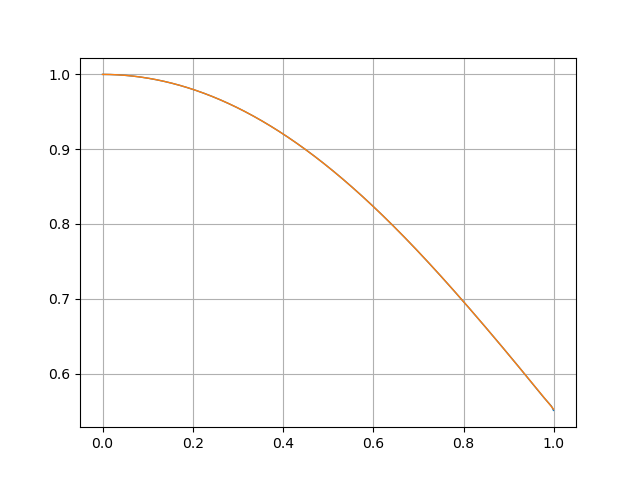

In [19]:
%matplotlib notebook
import math


def f(x, y):
    return x * math.exp(-x**2) - 2*x*y


density = 1000
c_threshold = 1e-3
n = 20
y0 = 1
alpha = 0
n_part = 15
a = 1
b = 1

ts = [i/density for i in range(density)]
ys = [find_solution(-math.log(1-t)/a, n, a, b, alpha, c_threshold, n_part, n) for t in ts]
solution_ys = [((t**2)/2+1)*math.exp(-t**2) for t in ts]

plt.plot(ts, ys, linewidth=1, label=f'The solution')
plt.plot(ts, solution_ys, linewidth=1, label=f'The exact solution')

plt.grid()
plt.show()

<IPython.core.display.Javascript object>


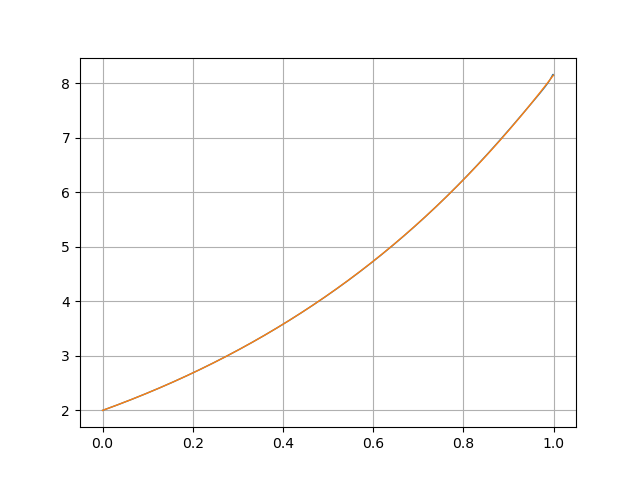

In [20]:
def f(x, y):
    return math.exp(x) + y


density = 2000
c_threshold = 1e-3
n = 20
y0 = 2
alpha = 0
n_part = 15
a = 2
b = 1

ts = [i/density for i in range(density)]
ys = [find_solution(-math.log(1-t)/a, n, a, b, alpha, c_threshold, n_part, n) for t in ts]
solution_ys = [(t + 2) * math.exp(t) for t in ts]

plt.plot(ts, ys, linewidth=1, label=f'The solution')
plt.plot(ts, solution_ys, linewidth=1, label=f'The exact solution')

plt.grid()
plt.show()